In [1]:
from pyvispoly import Point, PolygonWithHoles, VisibilityPolygonCalculator, plot_polygon
import solver2
from CAGPSolverMIP import CAGPSolverMIP
from GreedyCAGP import get_greedy_solution
import networkx as nx
import matplotlib.pyplot as plt
import distinctipy as distcolors
import lzma

In [2]:
def convert_to_LinearRing(edges: list, pos: dict) -> list[Point]:
    ring = []
    cur_point = next(iter(pos))
    while len(pos):
        x, y = pos.pop(cur_point)
        ring.append(Point(x, y))
        cur_edge = [edge for edge in edges if edge[0] == cur_point or edge[1] == cur_point][0]
        cur_point = cur_edge[0] if cur_edge[1] == cur_point else cur_edge[1]
        edges.remove(cur_edge)
    return ring

In [3]:
G = nx.parse_graphml(lzma.open('/home/yanyan/PythonProjects/CAGP-Solver/db/sbgdb-20200507/polygons/random/fpg/fpg-poly_0000002000.graphml.xz').read())
pos = {}
for node in G.nodes(data=True):
    node_location = tuple(node[1].values())
    node_location = (float(node_location[0]), float(node_location[1]))
    pos[node[0]] = node_location

ring = convert_to_LinearRing(list(G.edges()), pos)
poly = PolygonWithHoles(ring)

Creating guard set...
Creating witness set...
Creating visibility and full graph...
Calculating greedy solution...
Generating edge clique covers...
Creating MIP solver...
Set parameter Username
Academic license - for non-commercial use only - expires 2024-12-14
Set parameter TimeLimit to value 300
Set parameter MemLimit to value 16
Set parameter LazyConstraints to value 1
Solving MIP...
Gurobi Optimizer version 11.0.0 build v11.0.0rc2 (linux64 - "Ubuntu 22.04.2 LTS")

CPU model: AMD Ryzen 7 7800X3D 8-Core Processor, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 51411 rows, 8005 columns and 294815 nonzeros
Model fingerprint: 0xc2c61fdc
Variable types: 0 continuous, 8005 integer (8004 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 4e+00]
  RHS range        [1e+00, 1e+00]
Presolve added 0 rows and 1 columns
Presolve r

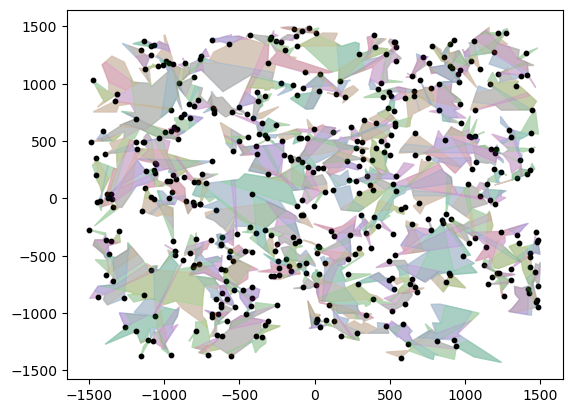

In [4]:
print('Creating guard set...')
guards = solver2.generate_guard_set(poly)
print('Creating witness set...')
witnesses = solver2.generate_witness_set(poly)
# GC = solver2.generate_visibility_graph(guards)
# GW = solver2.generate_covering_graph(guards, witnesses)
print('Creating visibility and full graph...')
GC, G = solver2.generate_visibility_and_full_graph(guards, witnesses)
print('Calculating greedy solution...')
# greedySolution = get_greedy_solution(guards, witnesses, GC)
# print("size of greedy solution: ", len(greedySolution))
print('Generating edge clique covers...')
edge_clique_covers = solver2.generate_edge_clique_covers(GC, 4)
print('Creating MIP solver...')
solverMIP = CAGPSolverMIP(4, poly, guards, witnesses, G, edge_clique_covers)
print('Solving MIP...')
solution = solverMIP.solve()

print('Plotting...')
colors = distcolors.get_colors(len(guards))
fig, ax = plt.subplots()
plot_polygon(poly, ax=ax, color="lightgrey")
for s in solution:
    for guard in guards:
        if s.split('k')[0] == guard.id:
            plot_polygon(guard.visibility, ax=ax, color=colors[int(s.split('k')[1])], alpha=0.1)
            plt.scatter(guard.position.x(), guard.position.y(), color='black', s=10)
            

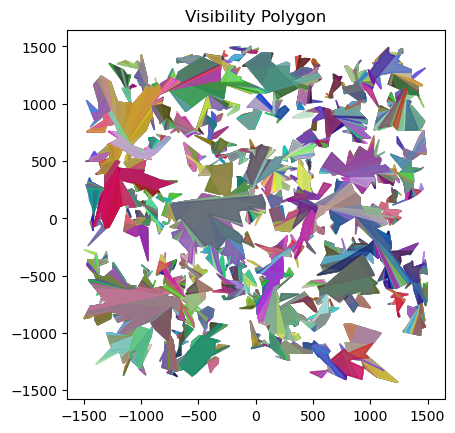

In [5]:
fig, ax = plt.subplots()
# plot_polygon(poly, ax=ax, color="lightgrey")

vis_poly_calc = VisibilityPolygonCalculator(poly)

colors = distcolors.get_colors(len(ring))
vis_polygons = {}

color = 0
for point in ring:
    vis_poly = vis_poly_calc.compute_visibility_polygon(point)
    plot_polygon(vis_poly, ax=ax, color=colors[color], alpha=0.5)
    vis_polygons[(float(point.x()), float(point.y()))] = PolygonWithHoles(vis_poly)
    color += 1

# keys = list(vis_polygons)
# for point1 in keys:
#     color = np.random.rand(3,)
#     for point2 in keys:
#         if point1 == point2:
#             continue
#         if not vis_polygons.get(point1).difference(vis_polygons.get(point2)):
#             x, y = [point1[0], point2[0]], [point1[1], point2[1]]
#             plt.plot(x, y, marker = 'o', color='black', linewidth=0.5)
#             continue
#         if vis_polygons.get(point1).difference(vis_polygons.get(point2))[0].outer_boundary().area() < vis_polygons.get(point1).outer_boundary().area():
#             x, y = [point1[0], point2[0]], [point1[1], point2[1]]
#             plt.plot(x, y, marker = 'o', color='black', linewidth=0.5)

plt.rcParams['figure.dpi']=10000
ax.set_aspect('equal')
plt.title("Visibility Polygon")
plt.show()
